# Simple Toy TS Training for Deep3D+

In [5]:
"""
Simple tester for the deep3d
"""
import tensorflow as tf
import Deep3D as deep3d
import utils
import numpy as np
import os
import os.path
import h5py
import matplotlib as plt

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Importing Data from H5 Format for fast loading
- Will eventually unit test dynamic CPU data loading pipeline here

In [6]:
#inria_file = '/a/data/deep3d_data/inria_data.h5'
inria_file = './inria_data.h5'
h5f = h5py.File(inria_file,'r')

X_train_0 = h5f['X_0'][:,10:170,16:304,:]
Y_train_0 = h5f['Y_0'][:,10:170,16:304,:]
X_train_1 = h5f['X_1'][:,10:170,16:304,:]
Y_train_1 = h5f['Y_1'][:,10:170,16:304,:]
X_train_2 = h5f['X_2'][:,10:170,16:304,:]
Y_train_2 = h5f['Y_2'][:,10:170,16:304,:]
X_train_3 = h5f['X_3'][:,10:170,16:304,:]
Y_train_3 = h5f['Y_3'][:,10:170,16:304,:]

X_val = h5f['X_4'][:,10:170,16:304,:]
Y_val = h5f['Y_4'][:,10:170,16:304,:]
  
h5f.close()

In [3]:
X_train = np.concatenate([X_train_0,X_train_1,X_train_2,X_train_3])
Y_train = np.concatenate([Y_train_0,Y_train_1,Y_train_2,Y_train_3])

print "Training Size:" + str(X_train.shape)
print "Validation Size:" + str(X_val.shape)

Training Size:(500, 160, 288, 3)
Validation Size:(500, 160, 288, 3)


## Training Loop

In [11]:
num_batches = 20
batchsize = 32
print_step = 1
#cost_hist = []
viz_step = 10

# Define config for GPU memory debugging 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True  # Switch to True for dynamic memory allocation instead of TF hogging BS
config.gpu_options.per_process_gpu_memory_fraction= 1  # Cap TF mem usage

with tf.device('/gpu:0'):
#with tf.device('/gpu:0'):  
    # Session
    sess = tf.Session(config=config)
    # Placeholders
    images = tf.placeholder(tf.float32, [batchsize, 160, 288, 3])
    true_out = tf.placeholder(tf.float32, [batchsize, 160, 288, 3])
    train_mode = tf.placeholder(tf.bool)

    # Building Net based on VGG weights 
    net = deep3d.Deep3Dnet('./vgg19.npy')
    net.build(images, train_mode)

    # Print number of variables used: 143667240 variables, i.e. ideal size = 548MB
    print 'Variable count:'
    print(net.get_var_count())
    
    # Run initializer 
    sess.run(tf.global_variables_initializer())
    
    # Define Training Objectives
    cost = tf.reduce_sum(tf.abs(net.prob - true_out))
    train = tf.train.GradientDescentOptimizer(0.002).minimize(cost)
    
    # tensorboard operations to compile summary and then write into logs
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('./tensorboard_logs/')

    # Training Loop
    print ""
    print "== Start training =="
    for i in xrange(num_batches):
        # Creating Batch
        image_mask = np.random.choice(X_train.shape[0],batchsize)
        images_in = X_train[image_mask,:,:,:]
        labels_in = Y_train[image_mask,:,:,:]
        
        # Traing Step
        _, summary = sess.run([train, cost, merged], feed_dict={images: images_in, true_out: labels_in, train_mode: True})
        writer.add_summary(summary, i)

        # No longer needed: cost_hist.append(cost_val)
        # if i%print_step == 0:
        #     print ("({}/{})".format(i, num_batches).ljust(10) + ' | Cost: ' + str(cost_val))
        print "loop: " + str(i) + "of " + str(num_batches)
    print ""
    print "Training Completed, storing weights"
    # Store Traing Output
    net.save_npy(sess)

Variable count:
138408071



== Start training ==


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_3' with dtype float and shape [4,160,288,3]
	 [[Node: Placeholder_3 = Placeholder[dtype=DT_FLOAT, shape=[4,160,288,3], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'Placeholder_3', defined at:
  File "/usr/lib64/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib64/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-c45bb68cdaa6>", line 18, in <module>
    images = tf.placeholder(tf.float32, [batchsize, 160, 288, 3])
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1502, in placeholder
    name=name)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/jhoh10/Envs/deep-venv/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_3' with dtype float and shape [4,160,288,3]
	 [[Node: Placeholder_3 = Placeholder[dtype=DT_FLOAT, shape=[4,160,288,3], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


## Testing Output

In [68]:
del net

# Test
test_img = np.expand_dims(X_val[100], axis = 0)
test_ans = Y_val[100]


config = tf.ConfigProto()
config.gpu_options.allow_growth=False
config.gpu_options.per_process_gpu_memory_fraction= 1

with tf.device("/gpu:0"):
    sess = tf.Session(config=config)
    images = tf.placeholder(tf.float32, [1, 160, 288, 3])
    train_mode = tf.placeholder(tf.bool)
    
    net = deep3d.Deep3Dnet('./deep3d-save.npy')
    net.build(images, train_mode)
    sess.run(tf.global_variables_initializer())
    res, mask, up_3 = sess.run([net.prob, net.mask, net.up_3], feed_dict={images: test_img, train_mode: False})

--- Input ---


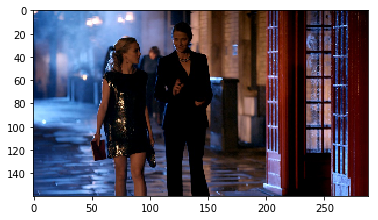

--- GT ---


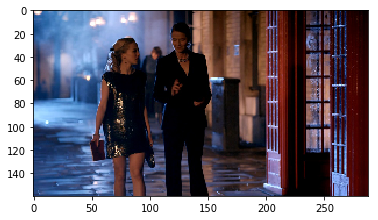

--- Our result ---


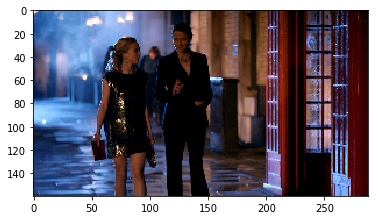

In [69]:
from matplotlib import pyplot
pyplot.figure()

print "--- Input ---"
pyplot.imshow(test_img[0])
pyplot.show()

print "--- GT ---"
pyplot.imshow(test_ans)
pyplot.show()

print "--- Our result ---"
pyplot.imshow(res[0])
pyplot.show()

#pyplot.imsave('1.jpeg', test_img[0])
#pyplot.imsave('2.jpeg', res[0])

## Looking at Disparity Maps

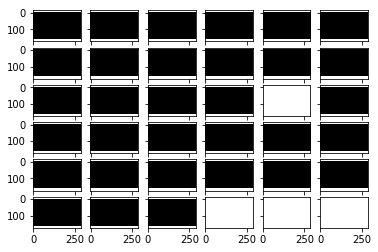

In [70]:
f, axs = pyplot.subplots(6, 6, sharex='col', sharey='row')

for i in range(33):
    axs[i/6][i%6].imshow(mask[0,:,:,i],cmap="gray",vmin=0.0, vmax=1.0)
pyplot.show()

In [71]:
max_shift_channel = np.argmax(mask,axis = 3)
max_shift_channel[0]

array([[16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       ..., 
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16]])